In [1]:
# =========================================================
# 1. MOUNT DRIVE
# =========================================================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile, os

zip_path = "/content/drive/MyDrive/forcI-dataset.zip"
extract_path = "/content/forcI-dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted.")


Dataset extracted.


In [3]:
import pandas as pd

dataset_path = "/content/forcI-dataset/forcI-dataset"

train_df = pd.read_csv(f"{dataset_path}/train.csv")
val_df   = pd.read_csv(f"{dataset_path}/val.csv")
test_df  = pd.read_csv(f"{dataset_path}/test.csv")

print(train_df.shape, val_df.shape, test_df.shape)


(41540, 10) (8901, 10) (8903, 10)


In [4]:
import pandas as pd

def build_input_text(row):
    title = row.get("title", "")
    abstract = row.get("abstract", "")
    authors = row.get("author", "")
    year = str(row.get("publication year", ""))
    publisher = row.get("publisher", "")
    doi = row.get("doi", "")

    if isinstance(doi, str) and "/" in doi:
        doi_prefix = doi.split("/")[0]
    else:
        doi_prefix = str(doi)

    def safe(x):
        if pd.isna(x) or x == "" or str(x).lower() == "nan":
            return "unknown"
        return str(x)

    text = (
        "[TITLE]\n" + safe(title) + "\n\n"
        "[ABSTRACT]\n" + safe(abstract) + "\n\n"
        "[AUTHORS]\n" + safe(authors) + "\n\n"
        "[YEAR]\n" + safe(year) + "\n\n"
        "[DOI]\n" + safe(doi_prefix) + "\n\n"
        "[PUBLISHER]\n" + safe(publisher)
    )
    return text

train_df["input_text"] = train_df.apply(build_input_text, axis=1)
val_df["input_text"]   = val_df.apply(build_input_text, axis=1)
test_df["input_text"]  = test_df.apply(build_input_text, axis=1)


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df["label_id"] = label_encoder.fit_transform(train_df["label"])
val_df["label_id"]   = label_encoder.transform(val_df["label"])

num_labels = len(label_encoder.classes_)
label2id = {v:k for k,v in enumerate(label_encoder.classes_)}
id2label = {k:v for k,v in enumerate(label_encoder.classes_)}


In [6]:
train_dataset = {
    "text": train_df["input_text"].tolist(),
    "labels": train_df["label_id"].tolist(),
}

val_dataset = {
    "text": val_df["input_text"].tolist(),
    "labels": val_df["label_id"].tolist(),
}


In [7]:
from transformers import AutoTokenizer

model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LEN = 1024


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [8]:
import torch
from torch.utils.data import Dataset

class FoRCDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        data = {
            "input_ids": item["input_ids"].squeeze(0),
            "attention_mask": item["attention_mask"].squeeze(0),
        }
        if self.labels is not None:
            data["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return data

train_data = FoRCDataset(train_dataset["text"], train_dataset["labels"])
val_data   = FoRCDataset(val_dataset["text"], val_dataset["labels"])


In [ ]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel

saved_path = "/content/drive/MyDrive/modernbert_epoch2"

print("Loading model from:", saved_path)

base_model = AutoModelForSequenceClassification.from_pretrained(
    saved_path,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Recreate same LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["Wqkv", "Wo"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(base_model, lora_config)
print("Model loaded and LoRA reapplied.")
model.print_trainable_parameters()


Loading model from: /content/drive/MyDrive/modernbert_epoch2


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Model loaded and LoRA reapplied.
trainable params: 2,392,443 || all params: 152,091,894 || trainable%: 1.5730


In [11]:
output_dir = "/content/drive/MyDrive/modernbert_continued"

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,     # training for 3 MORE epochs
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",      # save checkpoint per epoch
    load_best_model_at_end=False,
    fp16=True,
    report_to="none",
)


In [14]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="macro")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


In [15]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-2840886572.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
W1130 06:49:21.742000 645 torch/_inductor/utils.py:1558] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.660500,0.962129,0.705876,0.561431,0.533341,0.523280
2,2.884900,0.863958,0.742164,0.621495,0.588124,0.586627
3,2.334400,0.845378,0.753848,0.617413,0.602158,0.596984


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

TrainOutput(global_step=7791, training_loss=3.405685875263099, metrics={'train_runtime': 13117.211, 'train_samples_per_second': 9.5, 'train_steps_per_second': 0.594, 'total_flos': 8.68335404691456e+16, 'train_loss': 3.405685875263099, 'epoch': 3.0})

In [16]:
import os

base_dir = "/content/drive/MyDrive/modernbert_continued"

# List checkpoint folders
checkpoints = [d for d in os.listdir(base_dir) if d.startswith("checkpoint")]
checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

latest_ckpt = checkpoints[-1]
latest_path = os.path.join(base_dir, latest_ckpt)

print("Latest checkpoint loaded:", latest_path)


Latest checkpoint loaded: /content/drive/MyDrive/modernbert_continued/checkpoint-7791


In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    "answerdotai/ModernBERT-base",
    num_labels=123  # same as your training
)

# Load LoRA adapter on top of base model
model = PeftModel.from_pretrained(base_model, latest_path)

model.eval()
print("Model + LoRA checkpoint loaded successfully.")


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model + LoRA checkpoint loaded successfully.


In [18]:
from torch.utils.data import Dataset, DataLoader
import torch

MAX_LEN = 1024

class FoRCDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

val_dataset = FoRCDataset(val_df["input_text"].tolist(), val_df["label_id"].tolist())
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [19]:
import numpy as np

all_preds = []
all_labels = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for batch in val_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].cpu().numpy()

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.cpu().numpy()
        preds = np.argmax(logits, axis=-1)

    all_preds.extend(preds)
    all_labels.extend(labels)


/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

weighted_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
weighted_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
weighted_f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
accuracy = accuracy_score(all_labels, all_preds)

print("\n==== Weighted Metrics (Comparable to Paper) ====")
print("Accuracy:", round(accuracy, 4))
print("Weighted Precision:", round(weighted_precision, 4))
print("Weighted Recall:", round(weighted_recall, 4))
print("Weighted F1:", round(weighted_f1, 4))



==== Weighted Metrics (Comparable to Paper) ====
Accuracy: 0.7536
Weighted Precision: 0.7512
Weighted Recall: 0.7536
Weighted F1: 0.7501


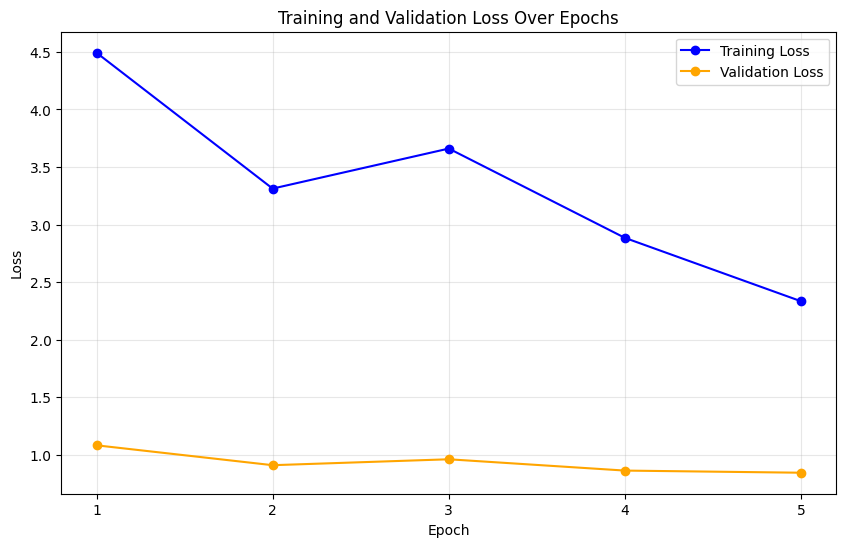

In [22]:
import matplotlib.pyplot as plt

# Epochs
epochs_initial = [1, 2]
epochs_continued = [3, 4, 5]

# Training and Validation Losses
train_loss_initial = [4.4928, 3.3128]
val_loss_initial = [1.083428, 0.910761]

train_loss_continued = [3.6605, 2.8849, 2.3344]
val_loss_continued = [0.962129, 0.863958, 0.845378]

# Combine for plotting
epochs_total = epochs_initial + epochs_continued
train_loss_total = train_loss_initial + train_loss_continued
val_loss_total = val_loss_initial + val_loss_continued

plt.figure(figsize=(10,6))
plt.plot(epochs_total, train_loss_total, marker='o', label='Training Loss', color='blue')
plt.plot(epochs_total, val_loss_total, marker='o', label='Validation Loss', color='orange')
plt.xticks(epochs_total)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


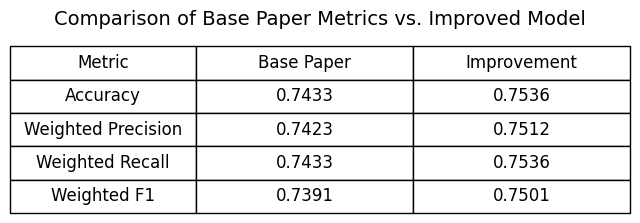

In [ ]:
import matplotlib.pyplot as plt

# Data
metrics = ["Accuracy", "Weighted Precision", "Weighted Recall", "Weighted F1"]
base_paper = [0.7433, 0.7423, 0.7433, 0.7391]  # from NRK FoRC paper
our_improvement = [0.7536, 0.7512, 0.7536, 0.7501]  # Our results

# Create figure
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')  # hide axes

# Create table data
table_data = [
    ["Metric", "Base Paper", "Improvement"]
] + [[m, f"{b:.4f}", f"{o:.4f}"] for m, b, o in zip(metrics, base_paper, our_improvement)]

# Add table to figure
table = ax.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.3, 0.35, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Title
plt.title("Comparison of Base Paper Metrics vs. Improved Model", fontsize=14, pad=20)

plt.show()
